# Resolution effects on TabularCEM
 
 The Chemical Evolution Model ``TabularCEM`` is meant to build models from tabulated data, allowing a much more flexible characterization of the evolution of galaxies in comparison with other analytic methods (e.g. log-normal SFH). The downside of tabulated star formation histories is that they rely on interpolation methods to perform the synthesis of multiple simple stellar populations.
 
In this tutorial, we explore the systematic effects of undersampling an analytic exponentially declining star formation history with a simple metal enrichment model.

- First, we compare the results of two ``TabularCEM``, sampled with different time resolutions, in terms of the predicted stellar mass and ISM metallicity function of time.
- Then, we use a SSP model to produce the spectral energy distribution of both CEM and explore the differences.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pst.SSP import PopStar
from pst import models
from astropy import units as u

First, we create our analytic prescription of the SFH and the metal enrichment as function of time

In [2]:
def exponential_sfh(time, tau):
    """Exponential declining SFH normalized to 1 Msun."""
    m =  (1 - np.exp(-time / tau)) 
    m /= m[-1]
    return m * u.Msun

def z_ism(time, alpha, z_0, t_0):
    """ISM metallicity history"""
    z = z_0 * (1 - np.power((time + t_0)/ t_0, alpha))
    return z * u.dimensionless_unscaled

Then, we will sample these function using a dense and coarse grid of time bins spaced logarithmically

In [3]:
# Dense
lbtime = np.geomspace(1e-3, 13.7, 300) * u.Gyr
time = 13.7 * u.Gyr - lbtime[::-1]
time[-1] = 13.7 * u.Gyr

# Coarse
lbtime2 = np.geomspace(1e-3, 13.7, 10) * u.Gyr
# lbtime2 = np.linspace(0, 1, 15)**2 * 13.7
time2 = 13.7 * u.Gyr - lbtime2[::-1]
time2[-1] = 13.7 * u.Gyr

# Lets create another time bin to fully sample the analytical model
dummy_t = np.linspace(0, 13.7, 1000) * u.Gyr

Next, we need to set up the default parameters of our analytical model. This is a critical part, as different values might result on smaller or larger differences in the resulting SED.

- ``tau`` determines how fast does the star formation history decline.
- ``alpha`` sets how fast does the metallicity evolution reach the saturation value.
- ``z_0`` corresponds to the saturation value of the metallicity evolution model.
- ``t_0`` sets the turn-off point of the metallicity evolution after which it rapidly saturates.

You can explore the effects of changing the default values of these parameters to better comprehend the intrinsic systematics of the model!

In [12]:
tau = 30.0 * u.Gyr
alpha = -2.0 
z_0 = 0.02
t_0 = 3.0  * u.Gyr

Now we can sample the model and create the input quantities for ``TabularCEM``

In [13]:
# Dense
m1 = exponential_sfh(time, tau)
z1 = z_ism(time, alpha, z_0, t_0)

# Coarse
m2 = exponential_sfh(time2, tau)
z2 = z_ism(time2, alpha, z_0, t_0)

Let's plot the points of the analytical model that are sampled on each realization

Text(0.5, 0, 'Cosmic time (Gyr)')

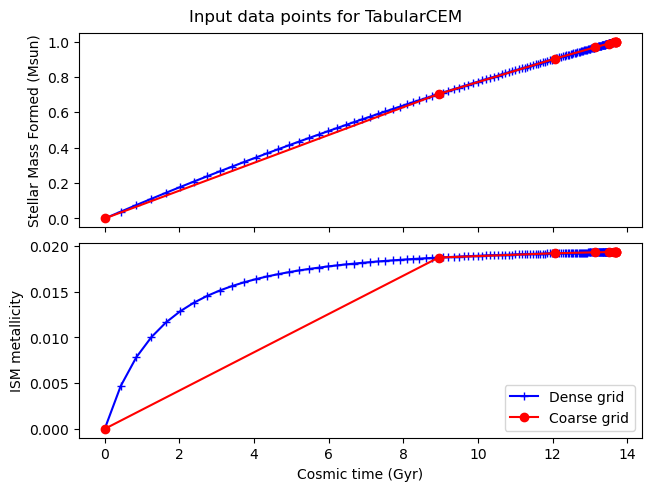

In [14]:
fig, axs = plt.subplots(nrows=2, sharex=True, constrained_layout=True)
fig.suptitle("Input data points for TabularCEM")
ax = axs[0]
ax.plot(time, m1, '-+', c="b", label="Dense grid")
ax.plot(time2, m2, '-o', c="r", label="Coarse grid")
ax.set_ylabel("Stellar Mass Formed (Msun)")

ax = axs[1]
ax.plot(time, z1, '-+', c="b", label="Dense grid")
ax.plot(time2, z2, '-o', c="r", label="Coarse grid")
ax.legend()
ax.set_ylabel("ISM metallicity")
ax.set_xlabel("Cosmic time (Gyr)")


Now we can finally initialise the ``TabularCEM`` with both grids

In [7]:
model1 = models.TabularCEM(times=time, masses=m1, metallicities=z1)
model2 = models.TabularCEM(times=time2, masses=m2, metallicities=z2)

To check the differences on the interpolation of the tabulated data between the two realizations of ``TabularCEM``, we will evaluate both models using the same grid of cosmic times (``dummy_t``)

Text(0.5, 0, 'Cosmic time (Gyr)')

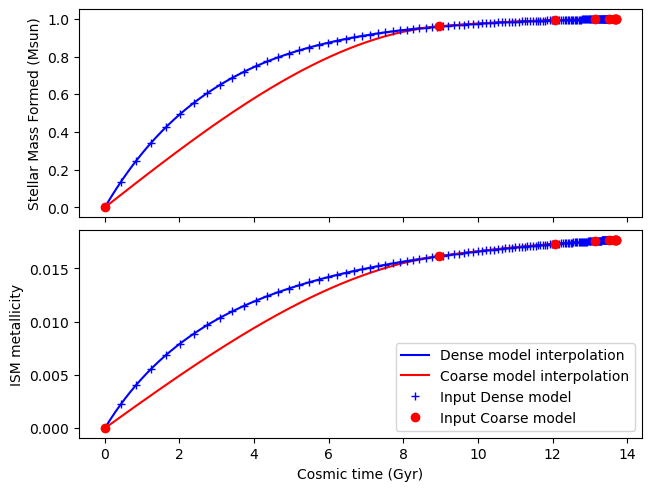

In [8]:
fig, axs = plt.subplots(nrows=2, sharex=True, constrained_layout=True)
ax = axs[0]
ax.plot(dummy_t, model1.stellar_mass_formed(dummy_t), c='b', label="Dense model interpolation")
ax.plot(dummy_t, model2.stellar_mass_formed(dummy_t), c='r', label="Coarse model interpolation")
ax.plot(time, m1, '+', c='b', label="Input Dense model")
ax.plot(time2, m2, 'o', c='r', label="Input Coarse model")
ax.set_ylabel("Stellar Mass Formed (Msun)")

ax = axs[1]
ax.plot(dummy_t, model1.ism_metallicity(dummy_t), c='b', label="Dense model interpolation")
ax.plot(dummy_t, model2.ism_metallicity(dummy_t), c='r', label="Coarse model interpolation")
ax.plot(time, z1, '+', c='b', label="Input Dense model")
ax.plot(time2, z2, 'o', c='r', label="Input Coarse model")
ax.legend()
ax.set_ylabel("ISM metallicity")
ax.set_xlabel("Cosmic time (Gyr)")


## Effects on the Spectral Energy Distribution

In this section we can compare the effects of using different resolutions when producing a ``TabularCEM``

First, we need to initialise a SSP model from which we can combine the individual SEDs into a composite spectra.

In [9]:
ssp = PopStar(IMF='cha')
ssp.cut_wavelength(3000, 11000)

> Initialising Popstar models (IMF='cha')
--> Only stellar continuum
[SSP] Models cut between 3000.0 Angstrom 11000.0 Angstrom


Now, we chose to produce two spectra observed at present time ($\sim13.7$ Gyr)

In [10]:
sed1 = model1.compute_SED(ssp, t_obs=13.7 * u.Gyr)
sed2 = model2.compute_SED(ssp, t_obs=13.7 * u.Gyr)

Finally, we can plot the differences between the two SEDs as function of wavelength

MEDIAN OFFSET:  1.0003420967700873


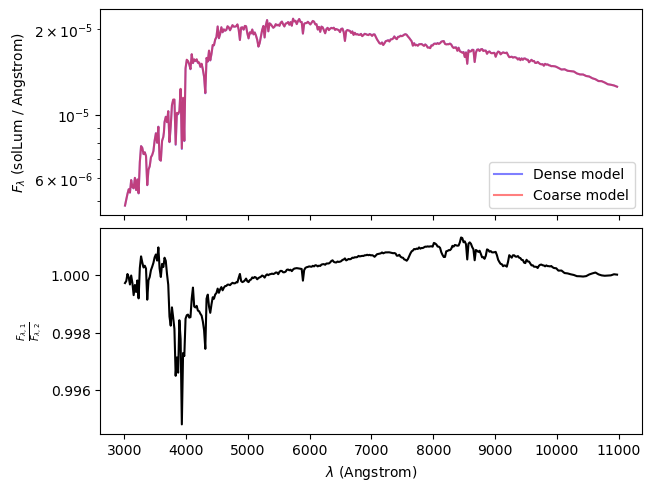

In [11]:
fig, axs = plt.subplots(nrows=2, constrained_layout=True, sharex=True)
ax = axs[0]
ax.plot(ssp.wavelength, sed1, alpha=0.5, label="Dense model", color='b')
ax.plot(ssp.wavelength, sed2, alpha=0.5, label="Coarse model", color='r')
ax.set_ylabel(r"$F_\lambda$" + f" ({sed1.unit})")
ax.set_yscale('log')
ax.legend()
ax = axs[1]
ax.plot(ssp.wavelength, sed1 / sed2, c='k')
ax.set_xlabel(r"$\lambda$" + f" ({ssp.wavelength.unit})")
ax.set_ylabel(r"$\frac{F_{\lambda, 1}}{F_{\lambda, 2}}$")

print("MEDIAN OFFSET: ", np.nanmedian(sed1 / sed2))